# Transfer learning and self-supervised learning

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math608/blob/master/static_files/presentations/11_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math608/blob/master/static_files/presentations/11_Transfer_learning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

## Setup

The following installation may take some time (~5min). If you do not want to run self-supervised learning you could comment out the first two packages.

In [1]:
%pip install git+https://github.com/tensorflow/similarity.git -qq
%pip install tensorflow-addons -qq
%pip install transformers datasets evaluate -qq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
# Python ≥3.7 is recommended
import sys
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥1.01 is recommended
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Tensorflow ≥2.8.0 is recommended
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow_datasets as tfds
import tensorflow_hub as hub

# Self-supervised learning (Comment below if you do not want to train the SSL model)
import tensorflow_similarity as tfsim
import tensorflow_addons as tfa

# Fintune CLIP, BERT, GPT
from transformers import pipeline
from transformers import AutoProcessor, TFAutoModelForZeroShotImageClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFAutoModelForCausalLM
from transformers import BertTokenizerFast, AutoModelForCausalLM
from transformers import TFAutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import create_optimizer
from transformers.keras_callbacks import KerasMetricCallback
from transformers.keras_callbacks import PushToHubCallback
from datasets import load_dataset
import evaluate

# Common imports
import numpy as np
import pandas as pd
from pathlib import Path
import random
import time
import os
import shutil, pathlib
import PIL.Image as Image
import requests

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

## Transfer learning on a small dataset

Here we will use the dataset that we have introduced in Lab 9.

### Downloading the data

The Dogs vs. Cats dataset that we will use isn’t packaged with Keras. It was made available by Kaggle as part of a computer vision competition in late 2013, back when convnets weren’t mainstream. You can download the original dataset from [www.kaggle.com/c/dogs-vs-cats/data](www.kaggle.com/c/dogs-vs-cats/data).

But you can also use Kaggle API. First, you need to create a Kaggle API key and download it to your local machine. Just navigate to the Kaggle website in a web browser, log in, and go to the My Account page. In your account settings, you’ll find an API section. Clicking the Create New API Token button will generate a kaggle.json key file and will download it to your machine.

<p align="center">
<img src="https://drive.google.com/uc?id=1Yo0bW4A59Se1EbE50JZMiWNueErB2eJa" alt="drawing" width="600"/>
</p>

In [ ]:
# Upload the API’s key JSON file to your Colab
# session by running the following code in a notebook cell:
from google.colab import files
files.upload()

Finally, create a `~/.kaggle` folder, and copy the key file to it. As a security best practice, you should also make sure that the file is only readable by the current user, yourself:

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# You can now download the data we’re about to use:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:22<00:00, 31.7MB/s]
100% 812M/812M [00:22<00:00, 37.3MB/s]


The first time you try to download the data, you may get a “403 Forbidden” error. That’s because you need to accept the terms associated with the dataset before you download it—you’ll have to go to www.kaggle.com/c/dogs-vs-cats/rules (while logged into your Kaggle account) and click the I Understand and Accept button. You only need to do this once.

In [ ]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

We now have 2,000 training images, 1,000 validation images, and 2,000 test images. Each split contains the same number of samples from each class: **this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of success.**

### Data preprocessing



In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Let’s look at the output of one of these Dataset objects: it yields batches of `180 × 180` RGB images (shape `(32, 180, 180, 3)`) and integer labels (shape `(32,)`). There are 32 samples in each batch (the batch size).

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


### Leveraging a pretrained model

A common and highly effective approach to deep learning on small image datasets is to use a pretrained model. A pretrained model is a model that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, the spatial hierarchy of features learned by the pretrained model can effectively act as a generic model of the visual world, and hence, its features can prove useful for many different computer vision problems, even though these new problems may involve completely different classes than those of the original task.

In this case, let’s consider a large convnet trained on the ImageNet dataset (1.2 million labeled images and 1,000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and you can thus expect it to perform well on the dogs-versus-cats classification problem. We’ll use the `VGG16` architecturetrained on ImageNet, to extract interesting features
from cat and dog images, and then train a dogs-versus-cats classifier on top of
these features. The `VGG16` model, among others, comes prepackaged with `tf.Keras`. You can import it from the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module.



In [ ]:
conv_base = tf.keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 2s 0us/step


We pass three arguments to the constructor:

* `weights` specifies the weight checkpoint from which to initialize the model.
* `include_top` refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because we intend to use our own densely connected classifier (with only two classes: cat and dog), we don't need to include it.
* `input_shape` is the shape of the image tensors that we'll feed to the network. This argument is purely optional: if we don't pass it, the network will be able to process inputs of any size. Here we pass it so that we can visualize (in the following `summary`) how the size of the feature maps shrinks with each new convolution and pooling layer.

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

The final feature map has shape `(5, 5, 512)`. That's the feature map on top of which we'll stick a densely connected classifier. At this point, there are two ways we could proceed:

1. Run the convolutional base over our dataset, record its output to a `NumPy` array on disk, and then use this data as input to a standalone, densely connected classifier. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, **this technique won't allow us to use data augmentation**.

2. Extend the model we have (`conv_base`) by adding `Dense` layers on top, and run the whole thing from end to end on the input data. This will allow us to use
data augmentation, because every input image goes through the convolutional base every time it's seen by the model. But for the same reason, this technique is far more expensive than the first.

#### Fast feature extration

We'll start by extracting features as `NumPy` arrays by calling the `predict()` method of the `conv_base` model on our training, validation, and testing datasets. Let's iterate over our datasets to extract the `VGG16` features.

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = tf.keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images, verbose=0)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

Importantly, `predict()` only expects images, not labels, but our current dataset yields batches that contain both images and their labels. Moreover, the `VGG16` model expects inputs that are **preprocessed with the function `tf.keras.applications.vgg16.preprocess_input`**, which scales pixel values to an appropriate range.

In [ ]:
train_features.shape

(2000, 5, 5, 512)

#### Defining and training the densely connected classifier

At this point, we can define our densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that we just recorded.

In [ ]:
tf.keras.backend.clear_session()
# 1. Define the model
# Note the use of the Flatten layer before passing the
# features to a Dense layer.
inputs = tf.keras.Input(shape=(5, 5, 512))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# 2. Compile the model
model = tf.keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
model.summary()


# 3. Train the model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 256)               3277056   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,277,313
Trainable params: 3,277,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
63/63 [==============================] -

Training is very fast because we only have to deal with two `Dense` layers. Let's look at the loss and accuracy curves during training

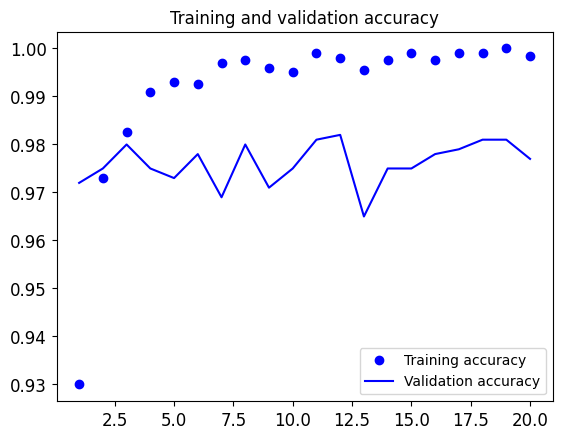

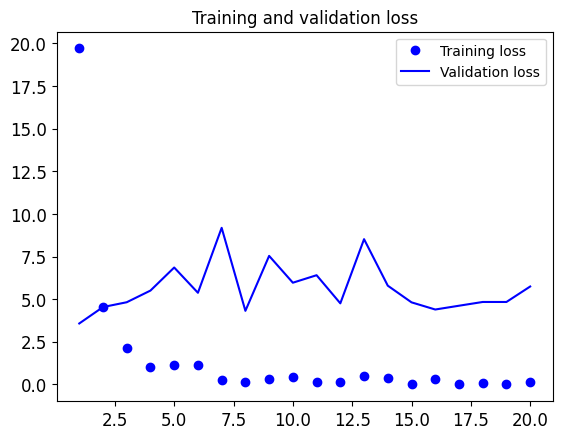

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We reach a validation accuracy between 97%~98% — much better than we achieved in Lab 9 with the small model trained from scratch. This is a bit of an unfair
comparison, however, because ImageNet contains many dog and cat instances, which means that our pretrained model already has the exact knowledge required for the task at hand. This won't always be the case when you use pretrained features.

However, the plots also indicate that we're overfitting almost from the start—
despite using dropout with a fairly large rate. That's because this technique doesn't use data augmentation, which is essential for preventing overfitting with small image datasets.

### Feature extraction together with data augmentation

Now let’s review the second technique for doing feature extraction, which is much slower and more expensive, but which allows us to use data augmentation
during training: creating a model that chains the `conv_base` with a new dense
classifier, and training it end to end on the inputs.

In order to do this, **we will first freeze the convolutional base**. Freezing a layer or set of layers means preventing their weights from being updated during training. If we don’t do this, the representations that were previously learned by the convolutional base will be modified during training. Because the `Dense` layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned. In `tf.Keras`, we freeze a layer or model by setting its `trainable` attribute to `False`.

In [ ]:
conv_base  = tf.keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [ ]:
conv_base.trainable_weights

[<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
 array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
           -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
          [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
           -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
          [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
           -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],
 
         [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
           -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
          [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
           -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
          [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
           -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],
 
         [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
           -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
    

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Now we can create a new model that chains together which contains a data augmentation stage, our frozen convolutional base and a dense classifier.

In [ ]:
tf.keras.backend.clear_session()
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.2),
    ]
)
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
# Apply input value scaling.
x = tf.keras.applications.vgg16.preprocess_input(x)
x = conv_base(x) # Fix weight
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                             

With this setup, only the weights from the two `Dense` layers that we added will be trained. **That’s a total of four weight tensors: two per layer (the main weight matrix and the bias vector)**. Note that in order for these changes to take effect, you must first compile the model. **If you ever modify weight trainability after compilation, you should then recompile the model, or these changes will be ignored.** 

Let’s train our model. Thanks to data augmentation, it will take much longer for
the model to start overfitting, so we can train for more epochs—let’s do 50.

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 9s 104ms/step - loss: 22.4581 - accuracy: 0.8925 - val_loss: 14.6266 - val_accuracy: 0.9340
Epoch 2/50
63/63 [==============================] - 5s 78ms/step - loss: 8.1973 - accuracy: 0.9400 - val_loss: 6.9847 - val_accuracy: 0.9630
Epoch 3/50
63/63 [==============================] - 6s 90ms/step - loss: 7.4329 - accuracy: 0.9510 - val_loss: 2.8821 - val_accuracy: 0.9810
Epoch 4/50
63/63 [==============================] - 5s 70ms/step - loss: 4.7731 - accuracy: 0.9595 - val_loss: 4.6078 - val_accuracy: 0.9720
Epoch 5/50
63/63 [==============================] - 6s 92ms/step - loss: 3.4647 - accuracy: 0.9690 - val_loss: 4.2702 - val_accuracy: 0.9710
Epoch 6/50
63/63 [==============================] - 6s 84ms/step - loss: 4.4984 - accuracy: 0.9680 - val_loss: 5.5084 - val_accuracy: 0.9700
Epoch 7/50
63/63 [==============================] - 6s 92ms/step - loss: 4.8084 - accuracy: 0.9630 - val_loss: 3.6594 - val_accuracy: 0.9810
Epoch 8/50

Let's plot the results again. As you can see, we reach a validation accuracy of about 98%. This is a strong improvement over the previous model.

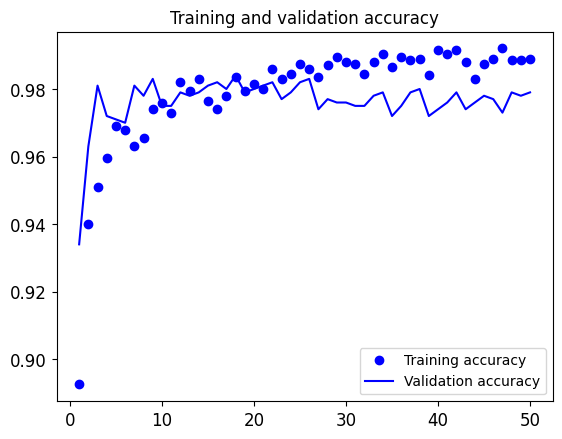

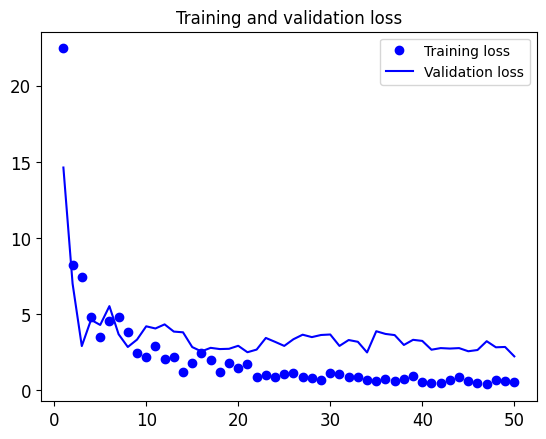

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = tf.keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 42ms/step - loss: 2.5062 - accuracy: 0.9775
Test accuracy: 0.978


We get a test accuracy of 97.8%!

### Fine-tuning a pretrained model

We stated earlier that it's necessary to freeze the convolution base of `VGG16` in order to be able to train a randomly initialized classifier on top. For the
same reason, it's only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classifier isn't already trained, the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. Thus the steps for fine-tuning a network are as follows:

1. Add our custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added.
4. Unfreeze some layers in the base network. (Note that usually you should not unfreeze “batch normalization” layers, which are not relevant here since there are no such layers in VGG16. Batch normalization and its impact on finetuning is explained in the lecture.)
5. Jointly train both these layers and the part we added.

You already completed the first three steps when doing feature extraction. Let's proceed with step 4: we'll unfreeze our `conv_base` and then freeze individual layers inside it.

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

We'll fine-tune the last three convolutional layers, which means all layers up to `block4_pool` should be frozen, and the layers `block5_conv1`, `block5_conv2`, and `block5_conv3` should be trainable.

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Now we can begin fine-tuning the model. We'll do this with the `RMSprop` optimizer, using a **very low learning rate**. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the three layers we're fine-tuning. Updates that are too large may harm these representations.

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 10s 100ms/step - loss: 0.5517 - accuracy: 0.9925 - val_loss: 2.2310 - val_accuracy: 0.9800
Epoch 2/30
63/63 [==============================] - 5s 72ms/step - loss: 0.3904 - accuracy: 0.9900 - val_loss: 2.4200 - val_accuracy: 0.9800
Epoch 3/30
63/63 [==============================] - 6s 91ms/step - loss: 0.4373 - accuracy: 0.9900 - val_loss: 2.3136 - val_accuracy: 0.9770
Epoch 4/30
63/63 [==============================] - 5s 71ms/step - loss: 0.4454 - accuracy: 0.9925 - val_loss: 2.3906 - val_accuracy: 0.9760
Epoch 5/30
63/63 [==============================] - 6s 91ms/step - loss: 0.1972 - accuracy: 0.9955 - val_loss: 2.4696 - val_accuracy: 0.9790
Epoch 6/30
63/63 [==============================] - 5s 69ms/step - loss: 0.2334 - accuracy: 0.9940 - val_loss: 2.4251 - val_accuracy: 0.9780
Epoch 7/30
63/63 [==============================] - 6s 91ms/step - loss: 0.4201 - accuracy: 0.9920 - val_loss: 2.1063 - val_accuracy: 0.9820
Epoch 8/30


In [ ]:
model = tf.keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 41ms/step - loss: 2.0598 - accuracy: 0.9755
Test accuracy: 0.975


Here, we get a test accuracy of 97.5%! By leveraging modern deep learning techniques, we managed to reach this result using only a small fraction of the training data that was available for the competition (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

## Using Tensorflow Hub

[TensorFlow Hub](https://www.tensorflow.org/hub) is a repository of pre-trained TensorFlow models.

### Download the classifier

Select a `MobileNetV2` pre-trained model from TensorFlow Hub and wrap it as a `tf.Keras` layer with `hub.KerasLayer`. [Any compatible image classifier model from TensorFlow Hub](https://tfhub.dev/s?module-type=image-classification&tf-version=tf2) will work here, including the examples provided in the drop-down below.

In [4]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
classifier_model = mobilenet_v2

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


61306/61306 [==============================] - 0s 1us/step


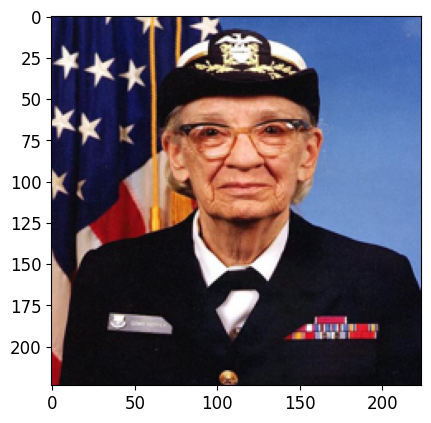

In [5]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
plt.imshow(grace_hopper);

Add a batch dimension (with `np.newaxis`) and pass the image to the model:

In [ ]:
grace_hopper = np.array(grace_hopper)/255.0
result = classifier.predict(grace_hopper[np.newaxis, ...])

1/1 [==============================] - 1s 686ms/step


The top class ID can be found with `tf.math.argmax()`:

In [ ]:
predicted_class = tf.math.argmax(result[0], axis=-1)

Take the `predicted_class` ID and fetch the ImageNet dataset labels to decode the predictions:

10484/10484 [==============================] - 0s 0us/step


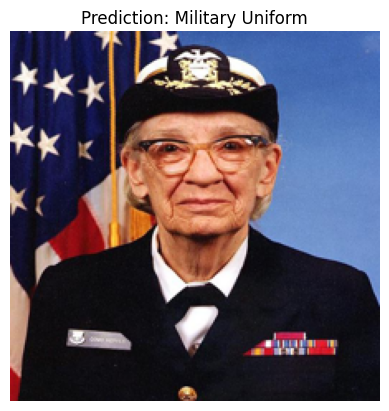

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

### Transfer learning

In this example, you will use the TensorFlow flowers dataset:

In [ ]:
data_root = tf.keras.utils.get_file(
  'flower_photos',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228813984/228813984 [==============================] - 6s 0us/step


First, load this data into the model using the image data off disk with `tf.keras.utils.image_dataset_from_directory()`, which will generate a `tf.data.Dataset`:

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


The flowers dataset has five classes:

In [ ]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Second, because TensorFlow Hub's convention for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling()` preprocessing layer to achieve this.

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

Third, finish the input pipeline by using buffered prefetching with `Dataset.prefetch()`, so you can yield the data from disk without I/O blocking issues.These are some of the most important `tf.data` methods you should use when loading data. Interested readers can learn more about them, as well as how to cache data to disk and other techniques, in the [Better performance with the `tf.data` API guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


#### Run the classifier on a batch of images

In [ ]:
result_batch = classifier.predict(train_ds)
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

92/92 [==============================] - 7s 66ms/step


array(['cardoon', 'obelisk', "yellow lady's slipper", ...,
       "jack-o'-lantern", 'daisy', 'ice cream'], dtype='<U30')

Check how these predictions line up with the images:

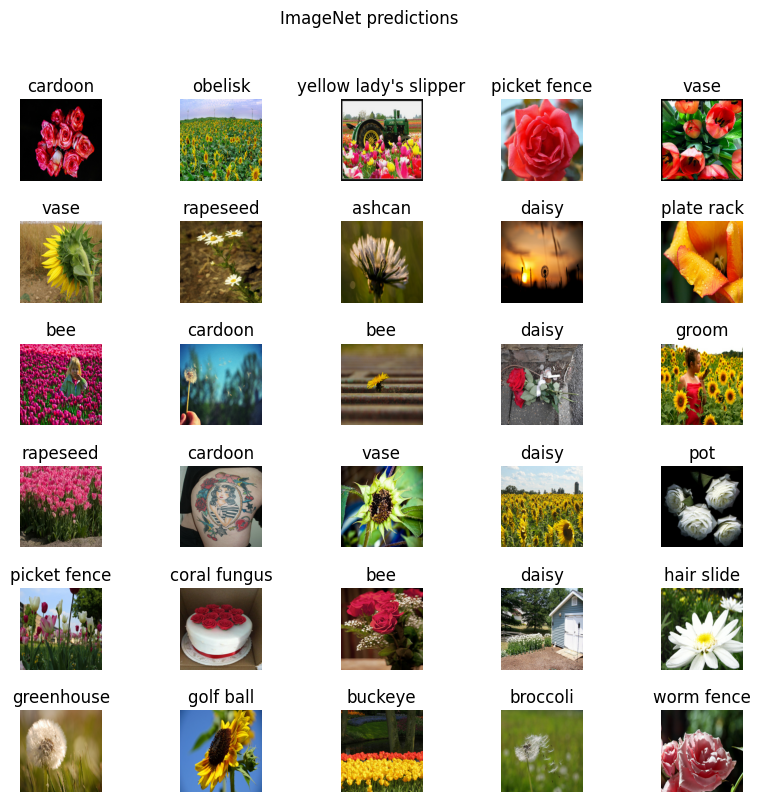

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except for "daisy").

#### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

In [ ]:
# Note that this time we select feature vector instead of classification
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_model = mobilenet_v2

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

Create the feature extractor by wrapping the pre-trained model as a Keras layer with hub.KerasLayer. Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


#### Attach a classification head

In [ ]:
tf.keras.backend.clear_session()
num_classes = len(class_names)

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


#### Train the model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Note there are no softmax at the model
    metrics=['acc'])

In [ ]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS)

Epoch 1/10
92/92 [==============================] - 9s 48ms/step - loss: 0.7141 - acc: 0.7330 - val_loss: 0.4273 - val_acc: 0.8474
Epoch 2/10
92/92 [==============================] - 2s 25ms/step - loss: 0.3607 - acc: 0.8777 - val_loss: 0.3511 - val_acc: 0.8760
Epoch 3/10
92/92 [==============================] - 3s 30ms/step - loss: 0.2834 - acc: 0.9070 - val_loss: 0.3192 - val_acc: 0.8924
Epoch 4/10
92/92 [==============================] - 2s 25ms/step - loss: 0.2365 - acc: 0.9278 - val_loss: 0.3020 - val_acc: 0.9005
Epoch 5/10
92/92 [==============================] - 2s 25ms/step - loss: 0.2030 - acc: 0.9397 - val_loss: 0.2917 - val_acc: 0.9046
Epoch 6/10
92/92 [==============================] - 2s 25ms/step - loss: 0.1770 - acc: 0.9523 - val_loss: 0.2854 - val_acc: 0.9060
Epoch 7/10
92/92 [==============================] - 2s 26ms/step - loss: 0.1561 - acc: 0.9608 - val_loss: 0.2817 - val_acc: 0.9046
Epoch 8/10
92/92 [==============================] - 3s 27ms/step - loss: 0.1388 - a

Obtain the ordered list of class names from the model predictions:

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 0s 483ms/step
['roses' 'sunflowers' 'tulips' 'roses' 'tulips' 'sunflowers' 'daisy'
 'dandelion' 'dandelion' 'tulips' 'tulips' 'dandelion' 'dandelion' 'roses'
 'sunflowers' 'tulips' 'roses' 'sunflowers' 'sunflowers' 'roses' 'tulips'
 'roses' 'roses' 'tulips' 'daisy' 'dandelion' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'dandelion' 'sunflowers']


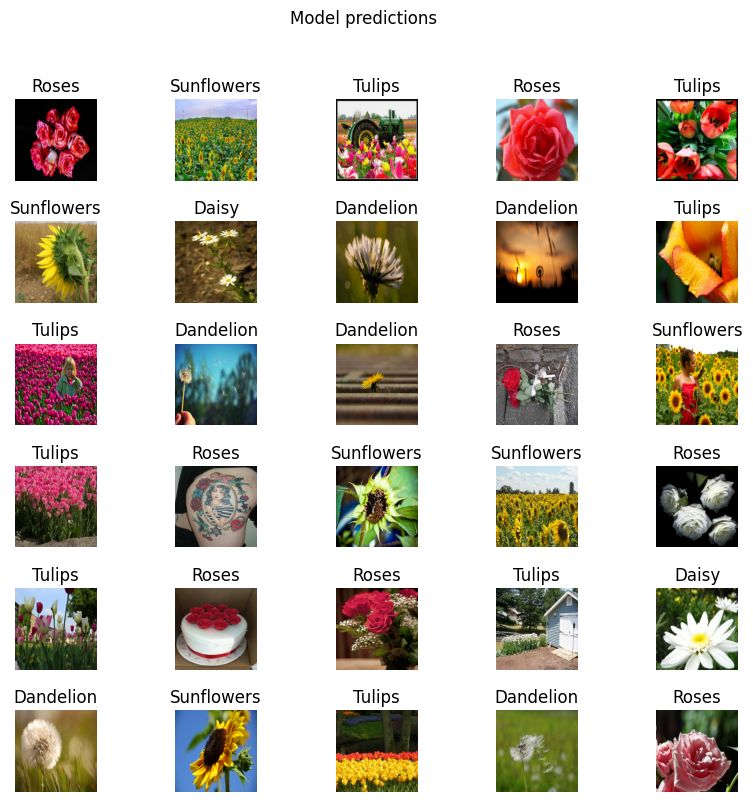

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_label_batch[n].title())
    plt.axis('off')
_ = plt.suptitle("Model predictions")

#### Export and reload your model

In [ ]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

'/tmp/saved_models/1683952799'

In [ ]:
reloaded = tf.keras.models.load_model(export_path)
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)
abs(reloaded_result_batch - result_batch).max()

1/1 [==============================] - 1s 1s/step


0.0

## Pretrain an image model with Self-supervised learning using SimSiam (Optional)

[TensorFlow Similarity](https://github.com/tensorflow/similarity) is a python package focused on making similarity learning and self-supervised learning quick and easy. Self-supervised learning is an approach to pre-training models using unlabeled data. The key insight is that you can train a self-supervised model to learn data representations by contrasting multiple augmented views of the same example. These learned representations capture data invariants, e.g., object translation, color jitter, noise, etc. Training a simple linear classifier on top of the frozen representations is easier and requires fewer labels because the pre-trained model already produces meaningful and generally useful features. Overall, self-supervised pre-training learns representations which are more [generic](https://arxiv.org/abs/2110.00528) and [robust](https://arxiv.org/abs/1902.01889) than other approaches to augmented training and pre-training. 

Tensorflow Similarity provides a set of network architectures, losses, and data augmentations that are common across a number of self-supervised learning techniques. The Tensorflow Similarity package attempts to provide a consistent terminology across these techniques; however, this leads to slightly different naming conventions, as many papers use different terms to describe the same components. The main terms used by Tensorflow Similarity are:

* **View**: A view represents an augmented example.

* **Backbone**: Refers to the model that learns the **Representation** that we will use for downstream tasks.

* **Projector**: Is an MLP model that projects the backbone representation of a view to an **Embedding** that is contrasted with other views using a specialized contrastive loss.

* **Predictor**: Is an optional MLP model that is used, in conjunction with gradient stopping, in some recent architectures to further improve the representation quality.

* **Stop Gradient**: Is used by some algorithms to ensure that we only propagate the update from the main view and not the contrasting view.


![contrastive_model_terms.png](https://raw.githubusercontent.com/tensorflow/similarity/master/assets/images/contrastive_model_terms.png)

We will demonstrates how to use Tensorflow Similarity to boost classification accuracy by pre-training a `ResNet18` model using contrastive learning on the cifar10 dataset. As you will see, the pre-trained model achieves about ~1.6x the accuracy of the model trained without pre-training. For example, **using SimSiam pre-training, you can achieve 80% accuracy versus 50% accuracy when training the same architecture from scratch**.

### Dataset Preperation

The following section:

* Loads the [CIFAR10](https://www.tensorflow.org/datasets/catalog/cifar10) data from tensorflow datasets.
* Creates the train, val, test, and query/index splits.

The TensorFlow Datasets' CIFAR10 dataset provides a test and train split. However, we are going to partition the train data into the following additional splits:

* **Validation**: Data used for validation metrics during the pre-training phase. 
* **Query and Index**: Data used to compute matching metrics. The query data is used to retrieve the nearest indexed examples.

In particular, the Query and Index split allows us to track the matching classification performance during training. 

**An increasing match accuracy is a strong indication that the model is learning useful features, however, it does require that we have labeled data. If a dataset only has a small number of labeled examples, they can be passed as the query and index to help monitor the potential matching classification performance during training.** 

In [ ]:
DATA_PATH = Path("tfsim_contrastive_model")
if not DATA_PATH.exists():
    DATA_PATH.mkdir(parents=True)

((x_raw_train, y_raw_train), (x_test, y_test)), ds_info = tfds.load(
    "cifar10",
    split=["train", "test"],
    batch_size=-1,
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteYHBS25/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteYHBS25/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# Compute the indicies for query, index, val, and train splits
query_idxs, index_idxs, val_idxs, train_idxs = [], [], [], []
for cid in range(ds_info.features["label"].num_classes):
    idxs = tf.random.shuffle(tf.where(y_raw_train == cid))
    idxs = tf.reshape(idxs, (-1,))
    query_idxs.extend(idxs[:200])  # 200 query examples per class
    index_idxs.extend(idxs[200:400])  # 200 index examples per class
    val_idxs.extend(idxs[400:500])  # 100 validation examples per class
    train_idxs.extend(idxs[500:])  # The remaining are used for training

random.shuffle(query_idxs)
random.shuffle(index_idxs)
random.shuffle(val_idxs)
random.shuffle(train_idxs)

In [ ]:
def create_split(idxs):
    x, y = [], []
    for idx in idxs:
        x.append(x_raw_train[int(idx)])
        y.append(y_raw_train[int(idx)])
    return tf.convert_to_tensor(np.array(x)), tf.convert_to_tensor(np.array(y))


x_query, y_query = create_split(query_idxs)
x_index, y_index = create_split(index_idxs)
x_val, y_val = create_split(val_idxs)
x_train, y_train = create_split(train_idxs)

In [ ]:
pd.DataFrame(
        [
            ["train", x_train.shape, y_train.shape],
            ["val", x_val.shape, y_val.shape],
            ["query", x_query.shape, y_query.shape],
            ["index", x_index.shape, y_index.shape],
            ["test", x_test.shape, y_test.shape],
        ],
        columns=["Dataset", "Examples", "Labels"],
)

,Dataset,Examples,Labels
0,train,"(45000, 32, 32, 3)",(45000)
1,val,"(1000, 32, 32, 3)",(1000)
2,query,"(2000, 32, 32, 3)",(2000)
3,index,"(2000, 32, 32, 3)",(2000)
4,test,"(10000, 32, 32, 3)",(10000)


### Self-Supervised Training Setup

#### Self-Supervised Algorithm Selection

TensorFlow Similarity currently supports three different self-supervised models.

* [SimCLR](http://arxiv.org/abs/2002.05709): Only requires the Backbone and the projector and uses a contrastive cross-entropy loss.
* [SimSiam](https://arxiv.org/abs/2011.10566): Requires the Backbone, projector, and predictor and only compares the cosine distance between augmented views from the same example.
* [Barlow Twins](https://arxiv.org/abs/2103.03230): Only requires the Backbone and the projector and uses a loss that compares the feature covariance instead of contrasting the views.
* [VicReg](https://arxiv.org/abs/2105.04906): Only requires the Backbone and projector and uses a loss that enforces the learned representations to be invariant to random augmentations while preserving the covariance and variance information.

The `ALGORITHM` parameter is used throughout this notebook to set up the various architectures and the parameters defined below are set up to reproduce the results published in the papers. 

In [ ]:
ALGORITHM = "simsiam"  # @param ["barlow", "simsiam", "simclr", "vigreg"]

In [ ]:
CIFAR_IMG_SIZE = 32
BATCH_SIZE = 512
PRE_TRAIN_EPOCHS = 200
PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
VAL_STEPS_PER_EPOCH = 20
WEIGHT_DECAY = 5e-4
DIM = 2048  # The layer size for the projector and predictor models.
WARMUP_LR = 0.0
WARMUP_STEPS = 0
TEMPERATURE = None

if ALGORITHM == "simsiam":
    INIT_LR = 3e-2 * int(BATCH_SIZE / 256)
elif ALGORITHM == "barlow":
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule.
    WARMUP_STEPS = 1000
elif ALGORITHM == "simclr":
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule, see section B.1 in the paper.
    TEMPERATURE = 0.5  # Tuned for CIFAR10, see section B.9 in the paper.
elif ALGORITHM == "vicreg":
    INIT_LR = 1e-3 

#### Augmented View Configuration

Self-supervised networks require at least two augmented "views" of each example. This can be created using a DataSet and an augmentation function. The DataSet treats each example in the batch as its own class and then the augment function produces two separate views for each example. 

This means the resulting batch will yield tuples containing the two views, i.e., `Tuple[(BATCH_SIZE, 32, 32, 3), (BATCH_SIZE, 32, 32, 3)]`. TensorFlow Similarity provides several random augmentation functions, and here we combine augmenters from the `simCLR` module to replicate the augmentations used in `simsiam`.

In [ ]:
def img_scaling(img):
    return tf.keras.applications.imagenet_utils.preprocess_input(
        img, 
        data_format=None, 
        mode='torch')


@tf.function
def simsiam_augmenter(img, blur=True, area_range=(0.2, 1.0)):
    """SimSiam augmenter.

    The SimSiam augmentations are based on the SimCLR augmentations, but have
    some important differences.
    * The crop area lower bound is 20% instead of 8%.
    * The color jitter and grayscale are applied separately instead of together.
    * The color jitter ranges are much smaller.
    * Blur is not applied for the cifar10 dataset.

    args:
        img: Single image tensor of shape (H, W, C)
        blur: If true, apply blur. Should be disabled for cifar10.
        area_range: The upper and lower bound of the random crop percentage.

    returns:
        A single image tensor of shape (H, W, C) with values between 0.0 and 1.0.
    """
    # random resize and crop. Increase the size before we crop.
    img = tfsim.augmenters.augmentation_utils.cropping.crop_and_resize(
        img, CIFAR_IMG_SIZE, CIFAR_IMG_SIZE, area_range=area_range
    )
    
    # The following transforms expect the data to be [0, 1]
    img /= 255.
    
    # random color jitter
    def _jitter_transform(x):
        return tfsim.augmenters.augmentation_utils.color_jitter.color_jitter_rand(
            x,
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.1),
            "multiplicative",
        )

    img = tfsim.augmenters.augmentation_utils.random_apply.random_apply(_jitter_transform, p=0.8, x=img)

    # # random grayscale
    def _grascayle_transform(x):
        return tfsim.augmenters.augmentation_utils.color_jitter.to_grayscale(x)

    img = tfsim.augmenters.augmentation_utils.random_apply.random_apply(_grascayle_transform, p=0.2, x=img)

    # optional random gaussian blur
    if blur:
        img = tfsim.augmenters.augmentation_utils.blur.random_blur(img, p=0.5)

    # random horizontal flip
    img = tf.image.random_flip_left_right(img)
    
    # scale the data back to [0, 255]
    img = img * 255.
    img = tf.clip_by_value(img, 0., 255.)

    return img


@tf.function()
def process(img):
    view1 = simsiam_augmenter(img, blur=False)
    view1 = img_scaling(view1)
    view2 = simsiam_augmenter(img, blur=False)
    view2 = img_scaling(view2)
    return (view1, view2)


# Note that there is no label in the train_ds, instead the inputs are two views!
train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.repeat()
val_ds = val_ds.shuffle(1024)
val_ds = val_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

The following cell plots the pairs of augmented views side by side. This can be a useful sanity check as many augmentation functions are set up for the larger ImageNet examples and can be overly aggressive for smaller images found in CIFAR.

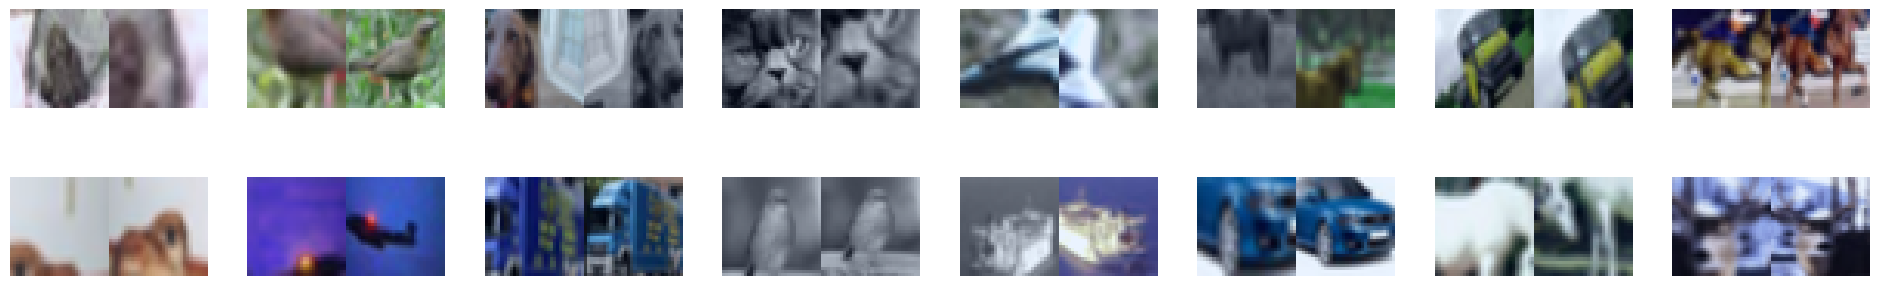

In [ ]:
display_imgs = next(train_ds.as_numpy_iterator())
max_pixel = np.max([display_imgs[0].max(), display_imgs[1].max()])
min_pixel = np.min([display_imgs[0].min(), display_imgs[1].min()])

tfsim.visualization.visualize_views(
    views=display_imgs,
    num_imgs=16,
    views_per_col=8,
    max_pixel_value=max_pixel,
    min_pixel_value=min_pixel,
)

### Contrastive Model Setup

The following section creates the sub-models used by the different algorithms. There are various architectures for building self-supervised models which may include some of the following:

* **Backbone**: This is the base model and is typically an existing architecture like ResNet or EfficientNet.
* **Projector**: This is a small multi-layer Neural Net and provides the embedding features at the end of training.
* **Predictor**: This model is used by BYOL and SimSiam and provides an additional small multi-layer Neural Net.
 
Typically, the projector and predictor networks are only 2 or 3 layers with batch normalization. Additionally, many papers show a single `encoder` block, but this often contains both the `Backbone` and the `Projector` network.
 
![contrastive_loss_functions.png](https://raw.githubusercontent.com/tensorflow/similarity/master/assets/images/contrastive_loss_functions.png)
 
The diagram above shows three self-supervised architectures supported by TensorFlow Similarity. As you can see, they all share a common structure:
* Processing multiple views of the same example.
* Using a backbone model for learning the representation output. 
* Using a projector for the embedding output.
* Additionally, note that the loss is symmetric, so we compute it twice during each step. First for view 1 and then a second time for view 2. These two losses are then summed up to compute the final aggregate loss.

#### Backbone Model

The backbone uses a custom version of `ResNet18` in order to reproduce the SimSiam CIFAR10 results.
 
**The ResNet models provided in `tf.keras.applications` use larger `[(1x1), (3x3), (1x1)]` blocks that can't be used to reproduce the SimSiam CIFAR10 results.**

In [ ]:
tf.keras.backend.clear_session()
def get_backbone(img_size, activation="relu", preproc_mode="torch"):
    input_shape = (img_size, img_size, 3)

    backbone = tfsim.architectures.ResNet18Sim(
        input_shape,
        include_top=False,  # Take the pooling layer as the output.
        pooling="avg",
    )
    return backbone


backbone = get_backbone(CIFAR_IMG_SIZE)
backbone.summary()

Model: "resnet18sim"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet18 (Functional)       (None, 4, 4, 512)         11182784  
                                                                 
 avg_pool (GlobalAveragePool  (None, 512)              0         
 ing2D)                                                          
                                                                 
Total params: 11,182,784
Trainable params: 11,173,056
Non-trainable params: 9,728
_________________________________________________________________


#### Projector Model

This MLP is common to all the self-supervised models and is typically a stack of 3 layers of the same size. However, SimSiam only uses 2 layers for the smaller CIFAR images. Having too much capacity in the models can make it difficult for the loss to stabilize and converge. Additionally, the SimSiam paper found that disabling the center and scale parameters can lead to a small boost in the final loss.
 
**Note this is the model output that is returned by `ContrastiveModel.predict()` and represents the distance based embedding. This embedding can be used for the KNN lookups and matching classification metrics. However, when using the pre-train model for downstream tasks, only the `ContrastiveModel.backbone` is used.**

In [ ]:
projector = None # Passing None will automatically build the default projector.

#### Predictor model

The predictor model is used by BYOL and SimSiam, and is an additional 2 layer MLP containing a bottleneck in the hidden layer.

In [ ]:
predictor = None # Passing None will automatically build the default predictor.

### Self-Supervised Algorithms

The following section builds the `ContrastiveModel` based on the `ALGORITHM` set at the start of the Notebook.
 
The model training is very sensitive to the learning rate decay and weight decay.
* **SimSiam**: Requires using SGD with weight decay from TF Addons. Adding weight decay as a kernel_regularizer doesn't seem to be able to reproduce the published results in the paper.
* **Barlow Twins**: We can use LAMB and avoid the need for the learning rate schedule. Lamb is similar to the LARS optimizer used in the Barlow paper, but includes the use of ADAM. Alternatively, we can use SGD but the optimizer requires a warm up period, otherwise the loss explodes.
* **SimCLR**: We can also use LAMB as the original paper uses LARS. However, LAMB seems to require smaller learning rates than shown for LARS in the original paper.

In [ ]:
contrastive_model = tfsim.models.create_contrastive_model(
    backbone=backbone,
    projector=projector,
    predictor=predictor,
    algorithm=ALGORITHM,
    name=ALGORITHM,
)

if ALGORITHM == "simsiam":
    loss = tfsim.losses.SimSiamLoss(projection_type="cosine_distance", name=ALGORITHM)
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=INIT_LR,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    wd_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=WEIGHT_DECAY,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    optimizer = tfa.optimizers.SGDW(learning_rate=lr_decayed_fn, weight_decay=wd_decayed_fn, momentum=0.9)
elif ALGORITHM == "barlow":
    loss = tfsim.losses.Barlow(name=ALGORITHM)
    optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
elif ALGORITHM == "simclr":
    loss = tfsim.losses.SimCLRLoss(name=ALGORITHM, temperature=TEMPERATURE)
    optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
elif ALGORITHM == "vicreg":
    loss = tfsim.losses.VicReg(name=ALGORITHM)
    optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
else:
    raise ValueError(f"{ALGORITHM} is not supported.")

In [ ]:
contrastive_model.compile(
    optimizer=optimizer,
    loss=loss,
)

contrastive_model.summary()

log_dir = DATA_PATH / "models" / "logs" / f"{loss.name}_{time.time()}"
chkpt_dir = DATA_PATH / "models" / "checkpoints" / f"{loss.name}_{time.time()}"


evb = tfsim.callbacks.EvalCallback(
    img_scaling(tf.cast(x_query, tf.float32)),
    y_query,
    img_scaling(tf.cast(x_index, tf.float32)),
    y_index,
    metrics=["binary_accuracy"],
    k=1,
    tb_logdir=log_dir,
)

mcp = tf.keras.callbacks.ModelCheckpoint(
    filepath=chkpt_dir,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
)

[Backbone]
Model: "resnet18sim"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet18 (Functional)       (None, 4, 4, 512)         11182784  
                                                                 
 avg_pool (GlobalAveragePool  (None, 512)              0         
 ing2D)                                                          
                                                                 
Total params: 11,182,784
Trainable params: 11,173,056
Non-trainable params: 9,728
_________________________________________________________________

[Projector]
Model: "projector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 projector_input (InputLayer  [(None, 512)]            0      

#### Training

The model training provides a number of metrics.
- **loss**: This represents the total loss over the contrastive batch. Separate contrastive and regularization losses will also be shown if there are trainable variables in the model layers.
- **proj_std and pred_std**: These are added as metric logging layers in the model and show the std of the activations of the final layer in the projector or predictor models.
- **binary_accuracy**: This is the nearest neighbor matching classification accuracy. A new index is built at the end of each epoch and the accuracy is computed using the query and index examples.

In [ ]:
# The training wil take long time, you can reduce the epoch if you really want to train
history = contrastive_model.fit(
    train_ds,
    epochs=PRE_TRAIN_EPOCHS,
    steps_per_epoch=PRE_TRAIN_STEPS_PER_EPOCH,
    validation_data=val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[evb, mcp],
    verbose=1,
)

Epoch 1/200
87/87 [==============================] - 38s 270ms/step - loss: 0.4331 - projector_loss: 0.2165 - proj_std: 0.0393 - pred_std: 0.0344 - val_loss: 0.2020 - val_projector_loss: 0.1010 - val_proj_std: 0.0280 - val_pred_std: 0.0244 - binary_accuracy: 0.1860
Epoch 2/200
87/87 [==============================] - 22s 248ms/step - loss: 0.2563 - projector_loss: 0.1281 - proj_std: 0.0413 - pred_std: 0.0396 - val_loss: 0.0945 - val_projector_loss: 0.0473 - val_proj_std: 0.0246 - val_pred_std: 0.0218 - binary_accuracy: 0.1875
Epoch 3/200
87/87 [==============================] - 21s 242ms/step - loss: 0.2271 - projector_loss: 0.1136 - proj_std: 0.0413 - pred_std: 0.0400 - val_loss: 0.1029 - val_projector_loss: 0.0515 - val_proj_std: 0.0280 - val_pred_std: 0.0257 - binary_accuracy: 0.2000
Epoch 4/200
87/87 [==============================] - 21s 248ms/step - loss: 0.2130 - projector_loss: 0.1065 - proj_std: 0.0414 - pred_std: 0.0402 - val_loss: 0.0924 - val_projector_loss: 0.0462 - val_pr

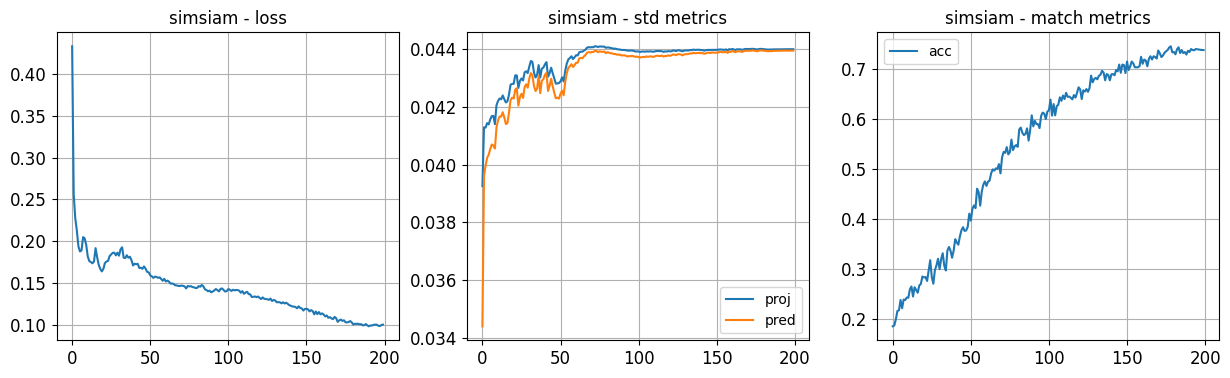

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history["loss"])
plt.grid()
plt.title(f"{loss.name} - loss")

plt.subplot(1, 3, 2)
plt.plot(history.history["proj_std"], label="proj")
if "pred_std" in history.history:
    plt.plot(history.history["pred_std"], label="pred")
plt.grid()
plt.title(f"{loss.name} - std metrics")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history["binary_accuracy"], label="acc")
plt.grid()
plt.title(f"{loss.name} - match metrics")
plt.legend()

plt.show()

#### Save and Reload

The `ContrastiveModel` contains a set of sub-models and custom train and test steps. Consequently, the `ContrastiveModel` implements a custom save function that performs the following:

* Saves each of the sub models, including the predictor if one exists.
* A JSON file containing the serialized Loss, Metrics, and Optimizer.
* The Optimizer weighs as a `npy` file.

In [ ]:
contrastive_model.save(DATA_PATH / "models" / "trained_model")

In [ ]:
del contrastive_model

In [ ]:
contrastive_model = tf.keras.models.load_model(
    DATA_PATH / "models" / "trained_model",
    custom_objects={
        "ContrastiveModel": tfsim.models.ContrastiveModel,
        "ActivationStdLoggingLayer": tfsim.layers.ActivationStdLoggingLayer,
    },
)

### Evaluation

This final section trains two different classifiers.
 
1. **No Pre-training**: Uses a ResNet18 model and a simple linear layer.
 
2. **Pre-trained** Uses the frozen pre-trained backbone from the ContrastiveModel and only trains the weights in the linear layer.
 
The original train data is partitioned into eval_train and eval_val splits and a simplified augmentation is applied to the training data. The models are then trained for 10 epochs and the classification accuracy is evaluated on the held out test split.

In [ ]:
TEST_EPOCHS = 10
TEST_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE

@tf.function
def eval_augmenter(img):
    # random resize and crop. Increase the size before we crop.
    img = tfsim.augmenters.augmentation_utils.cropping.crop_and_resize(
        img, CIFAR_IMG_SIZE, CIFAR_IMG_SIZE, area_range=(0.2, 1.0)
    )
    # random horizontal flip
    img = tf.image.random_flip_left_right(img)
    img = tf.clip_by_value(img, 0., 255.)

    return img

eval_train_ds = tf.data.Dataset.from_tensor_slices((x_train, tf.keras.utils.to_categorical(y_train, 10)))
eval_train_ds = eval_train_ds.repeat()
eval_train_ds = eval_train_ds.shuffle(1024)
eval_train_ds = eval_train_ds.map(lambda x, y: (eval_augmenter(x), y), tf.data.AUTOTUNE)
eval_train_ds = eval_train_ds.map(lambda x, y: (img_scaling(x), y), tf.data.AUTOTUNE)
eval_train_ds = eval_train_ds.batch(BATCH_SIZE)
eval_train_ds = eval_train_ds.prefetch(tf.data.AUTOTUNE)

eval_val_ds = tf.data.Dataset.from_tensor_slices((x_val, tf.keras.utils.to_categorical(y_val, 10)))
eval_val_ds = eval_val_ds.repeat()
eval_val_ds = eval_val_ds.shuffle(1024)
eval_val_ds = eval_val_ds.map(lambda x, y: (img_scaling(tf.cast(x, dtype=tf.float32)), y), tf.data.AUTOTUNE)
eval_val_ds = eval_val_ds.batch(BATCH_SIZE)
eval_val_ds = eval_val_ds.prefetch(tf.data.AUTOTUNE)

eval_test_ds = tf.data.Dataset.from_tensor_slices((x_test, tf.keras.utils.to_categorical(y_test, 10)))
eval_test_ds = eval_test_ds.map(lambda x, y: (img_scaling(tf.cast(x, dtype=tf.float32)), y), tf.data.AUTOTUNE)
eval_test_ds = eval_test_ds.batch(BATCH_SIZE)
eval_test_ds = eval_test_ds.prefetch(tf.data.AUTOTUNE)

def get_eval_model(img_size, backbone, total_steps, trainable=True, lr=1.8):
    backbone.trainable = trainable
    inputs = tf.keras.layers.Input((img_size, img_size, 3), name="eval_input")
    x = backbone(inputs, training=trainable)
    o = tf.keras.layers.Dense(10, activation="softmax")(x)
    model = tf.keras.Model(inputs, o)
    cosine_decayed_lr = tf.keras.experimental.CosineDecay(initial_learning_rate=lr, decay_steps=total_steps)
    opt = tf.keras.optimizers.SGD(cosine_decayed_lr, momentum=0.9)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])
    return model

#### No Pretrain

In [ ]:
no_pt_eval_model = get_eval_model(
    img_size=CIFAR_IMG_SIZE,
    backbone=get_backbone(CIFAR_IMG_SIZE, DIM),
    total_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH,
    trainable=True,
    lr=1e-3,
)

no_pt_history = no_pt_eval_model.fit(
    eval_train_ds,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    steps_per_epoch=TEST_STEPS_PER_EPOCH,
    validation_data=eval_val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Epoch 1/10
87/87 [==============================] - 21s 128ms/step - loss: 2.0807 - acc: 0.2465 - val_loss: 1.7362 - val_acc: 0.3757
Epoch 2/10
87/87 [==============================] - 10s 110ms/step - loss: 1.7352 - acc: 0.3550 - val_loss: 1.5761 - val_acc: 0.4279
Epoch 3/10
87/87 [==============================] - 10s 111ms/step - loss: 1.6550 - acc: 0.3953 - val_loss: 1.5116 - val_acc: 0.4521
Epoch 4/10
87/87 [==============================] - 10s 111ms/step - loss: 1.5952 - acc: 0.4177 - val_loss: 1.4707 - val_acc: 0.4760
Epoch 5/10
87/87 [==============================] - 10s 110ms/step - loss: 1.5585 - acc: 0.4317 - val_loss: 1.4327 - val_acc: 0.4843
Epoch 6/10
87/87 [==============================] - 10s 111ms/step - loss: 1.5225 - acc: 0.4487 - val_loss: 1.4095 - val_acc: 0.4852
Epoch 7/10
87/87 [==============================] - 10s 111ms/step - loss: 1.5051 - acc: 0.4555 - val_loss: 1.3930 - val_acc: 0.4961
Epoch 8/10
87/87 [==============================] - 10s 111ms/step - 

#### Pretrained

In [ ]:
pt_eval_model = get_eval_model(
    img_size=CIFAR_IMG_SIZE,
    backbone=contrastive_model.backbone,
    total_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH,
    trainable=False,
    lr=30.0,
)
pt_eval_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eval_input (InputLayer)     [(None, 32, 32, 3)]       0         
                                                                 
 resnet18sim (SimilarityMode  (None, 512)              11182784  
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 11,187,914
Trainable params: 5,130
Non-trainable params: 11,182,784
_________________________________________________________________


In [ ]:
pt_history = pt_eval_model.fit(
    eval_train_ds,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    steps_per_epoch=TEST_STEPS_PER_EPOCH,
    validation_data=eval_val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Epoch 1/10
87/87 [==============================] - 5s 35ms/step - loss: 32.3816 - acc: 0.1163 - val_loss: 36.2844 - val_acc: 0.1178
Epoch 2/10
87/87 [==============================] - 2s 26ms/step - loss: 29.9182 - acc: 0.1659 - val_loss: 10.1967 - val_acc: 0.1580
Epoch 3/10
87/87 [==============================] - 2s 27ms/step - loss: 3.0410 - acc: 0.6028 - val_loss: 0.7029 - val_acc: 0.7741
Epoch 4/10
87/87 [==============================] - 2s 26ms/step - loss: 0.7650 - acc: 0.7661 - val_loss: 0.6377 - val_acc: 0.7936
Epoch 5/10
87/87 [==============================] - 2s 26ms/step - loss: 0.7141 - acc: 0.7745 - val_loss: 0.5892 - val_acc: 0.7896
Epoch 6/10
87/87 [==============================] - 2s 27ms/step - loss: 0.6743 - acc: 0.7784 - val_loss: 0.5803 - val_acc: 0.7985
Epoch 7/10
87/87 [==============================] - 2s 27ms/step - loss: 0.6640 - acc: 0.7821 - val_loss: 0.5813 - val_acc: 0.7913
Epoch 8/10
87/87 [==============================] - 2s 27ms/step - loss: 0.6478

#### Comparison

In [ ]:
print("no pretrain", no_pt_eval_model.evaluate(eval_test_ds))
print("pretrained", pt_eval_model.evaluate(eval_test_ds))

20/20 [==============================] - 1s 66ms/step - loss: 1.3856 - acc: 0.5010
no pretrain [1.3856277465820312, 0.5009999871253967]
20/20 [==============================] - 0s 21ms/step - loss: 0.6054 - acc: 0.7963
pretrained [0.6053985953330994, 0.7962999939918518]


## Zero-shot image classification using CLIP

Zero-shot image classification is a task that involves classifying images into different categories using a model that was not explicitly trained on data containing labeled examples from those specific categories.

Traditionally, image classification requires training a model on a specific set of labeled images, and this model learns to "map" certain image features to labels. When there's a need to use such model for a classification task that introduces a new set of labels, fine-tuning is required to "recalibrate" the model. In contrast, zero-shot or open vocabulary image classification models are typically multi-modal models that have been trained on a large dataset of images and associated descriptions. These models learn aligned vision-language representations that can be used for many downstream tasks including zero-shot image classification.

This is a more flexible approach to image classification that allows models to generalize to new and unseen categories without the need for additional training data and enables users to query images with free-form text descriptions of their target objects .

### Zero-shot image classification pipeline

Start by loading the model and associated processor from a [checkpoint on the Hugging Face Hub](https://huggingface.co/models?pipeline_tag=zero-shot-image-classification&sort=downloads).
Here we'll use the checkpoint:

In [ ]:
checkpoint = "openai/clip-vit-large-patch14"

model = TFAutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-large-patch14.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Say, if we want to classifiy the following image:

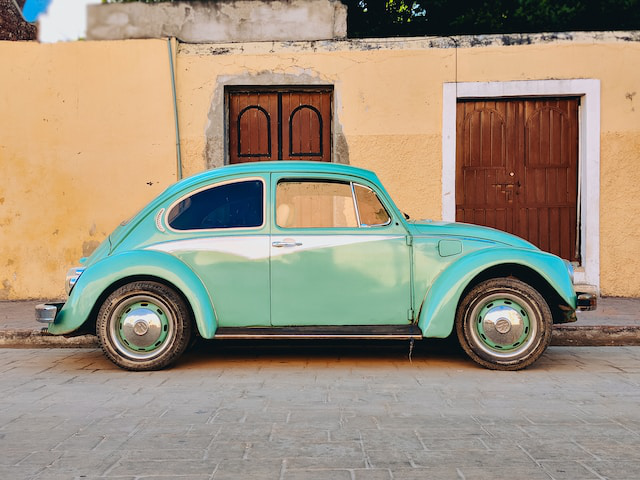

In [ ]:
url = "https://unsplash.com/photos/xBRQfR2bqNI/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjc4Mzg4ODEx&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)

image

Use the `processor` to prepare the inputs for the model. The `processor` combines an image processor that prepares the image for the model by resizing and normalizing it, and a tokenizer that takes care of the text inputs.

In [ ]:
candidate_labels = ["tree", "car", "bike", "cat"]
inputs = processor(images=image, text=candidate_labels, return_tensors="tf", padding=True)

Pass the inputs through the model, and post-process the results:

In [ ]:
outputs = model(**inputs)

# Assuming that 'outputs' is a dictionary and 'logits_per_image' is a key that returns a batch of logits
logits = outputs['logits_per_image'][0]

# Compute softmax probabilities
probs = tf.nn.softmax(logits, axis=-1).numpy()

# Assuming that 'candidate_labels' is a list of labels
result = [
    {"score": float(score), "label": candidate_label}
    for score, candidate_label in sorted(zip(probs, candidate_labels), key=lambda x: -x[0])
]

result

[{'score': 0.998578667640686, 'label': 'car'},
 {'score': 0.0010499537456780672, 'label': 'bike'},
 {'score': 0.00034005637280642986, 'label': 'tree'},
 {'score': 3.1229159503709525e-05, 'label': 'cat'}]

### Fintune the model

See [here](https://github.com/tensorflow/similarity/blob/master/examples/multimodal_example.ipynb) for more information.

## BERT

### Try out BERT

Feel free to swap out the sentence below for one of your own. However, leave [MASK] in somewhere to allow BERT to predict the missing word:

In [ ]:
unmasker = pipeline('fill-mask', model='bert-base-uncased', framework="tf")
unmasker("Artificial Intelligence [MASK] take over the world.")

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


[{'score': 0.3182392716407776,
  'token': 2064,
  'token_str': 'can',
  'sequence': 'artificial intelligence can take over the world.'},
 {'score': 0.18299587070941925,
  'token': 2097,
  'token_str': 'will',
  'sequence': 'artificial intelligence will take over the world.'},
 {'score': 0.056000713258981705,
  'token': 2000,
  'token_str': 'to',
  'sequence': 'artificial intelligence to take over the world.'},
 {'score': 0.04519489407539368,
  'token': 2015,
  'token_str': '##s',
  'sequence': 'artificial intelligences take over the world.'},
 {'score': 0.04515315219759941,
  'token': 2052,
  'token_str': 'would',
  'sequence': 'artificial intelligence would take over the world.'}]

For chinese, we can use the model from [https://github.com/ckiplab/ckip-transformers](https://github.com/ckiplab/ckip-transformers):

In [ ]:
unmasker = pipeline('fill-mask', model='ckiplab/albert-tiny-chinese')
unmasker("中[MASK]大學")

[{'score': 0.41772598028182983,
  'token': 1751,
  'token_str': '國',
  'sequence': '中 國 大 學'},
 {'score': 0.10670846700668335,
  'token': 2255,
  'token_str': '山',
  'sequence': '中 山 大 學'},
 {'score': 0.07562493532896042,
  'token': 3152,
  'token_str': '文',
  'sequence': '中 文 大 學'},
 {'score': 0.04743417352437973,
  'token': 1333,
  'token_str': '原',
  'sequence': '中 原 大 學'},
 {'score': 0.04172985255718231,
  'token': 4906,
  'token_str': '科',
  'sequence': '中 科 大 學'}]

### Fintune Bert

Text classification is a common NLP task that assigns a label or class to text. Some of the largest companies run text classification in production for a wide range of practical applications. One of the most popular forms of text classification is sentiment analysis.

This guide will show you how to:

1. Finetune [DistilBERT](https://huggingface.co/distilbert-base-uncased) on the [IMDb](https://huggingface.co/datasets/imdb) dataset to determine whether a movie review is positive or negative.
2. Use your finetuned model for inference.

#### Load IMDb dataset

In [ ]:
imdb = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Then take a look at an example:

In [ ]:
imdb["test"][0]

{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as 

There are two fields in this dataset:

- `text`: the movie review text.
- `label`: a value that is either `0` for a negative review or `1` for a positive review.

#### Preprocess

The next step is to load a `DistilBERT` tokenizer to preprocess the `text` field:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Create a preprocessing function to tokenize `text` and truncate sequences to be no longer than DistilBERT's maximum input length:

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

To apply the preprocessing function over the entire dataset, use Datasets [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) function. You can speed up `map` by setting `batched=True` to process multiple elements of the dataset at once:

In [ ]:
tokenized_imdb = imdb.map(preprocess_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Now create a batch of examples using [DataCollatorWithPadding](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorWithPadding). It's more efficient to *dynamically pad* the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

#### Evaluate

Including a metric during training is often helpful for evaluating your model's performance. You can quickly load a evaluation method with the [Evaluate](https://huggingface.co/docs/evaluate/index) library. For this task, load the [accuracy](https://huggingface.co/spaces/evaluate-metric/accuracy) metric (see the Evaluate [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour) to learn more about how to load and compute a metric). Then create a function that passes your predictions and labels to [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) to calculate the accuracy:

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

#### Train

Before you start training your model, create a map of the expected ids to their labels with `id2label` and `label2id`:

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

If you aren't familiar with finetuning a model with `Keras`, take a look at the basic tutorial [here](https://huggingface.co/docs/transformers/main/en/tasks/../training#train-a-tensorflow-model-with-keras)! To finetune a model in TensorFlow, start by setting up an optimizer function, learning rate schedule, and some training hyperparameters:

In [ ]:
batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_imdb["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

Then you can load DistilBERT with [TFAutoModelForSequenceClassification](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.TFAutoModelForSequenceClassification) along with the number of expected labels, and the label mappings:

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

Convert your datasets to the `tf.data.Dataset` format with [prepare_tf_dataset()](https://huggingface.co/docs/transformers/main/en/main_classes/model#transformers.TFPreTrainedModel.prepare_tf_dataset):

In [ ]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_imdb["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_imdb["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

model.compile(optimizer=optimizer)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


The last two things to setup before you start training is to compute the accuracy from the predictions, and provide a way to push your model to the Hub. Both are done by using [Keras callbacks](https://huggingface.co/docs/transformers/main/en/tasks/../main_classes/keras_callbacks). Pass your `compute_metrics` function to [KerasMetricCallback](https://huggingface.co/docs/transformers/main/en/main_classes/keras_callbacks#transformers.KerasMetricCallback).

In [ ]:
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

callbacks = [metric_callback]

In [ ]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3, callbacks=callbacks)

Epoch 1/3
1562/1562 [==============================] - 427s 256ms/step - loss: 0.2530 - val_loss: 0.1836 - accuracy: 0.9288
Epoch 2/3
1562/1562 [==============================] - 305s 195ms/step - loss: 0.1344 - val_loss: 0.1844 - accuracy: 0.9325
Epoch 3/3
1562/1562 [==============================] - 297s 190ms/step - loss: 0.0657 - val_loss: 0.2097 - accuracy: 0.9324


#### Inference

Great, now that you've finetuned a model, you can use it for inference! Grab some text you'd like to run inference on:

In [ ]:
text = "This was a masterpiece. Not completely faithful to the books, but enthralling from beginning to end. Might be my favorite of the three."

Get the class with the highest probability, and use the model's `id2label` mapping to convert it to a text label:

In [ ]:
inputs = tokenizer(text, return_tensors="tf")
logits = model(**inputs).logits
predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
model.config.id2label[predicted_class_id]

'POSITIVE'

## GPT

### Generate text

To see how greedy search works, let's start by loading the 1.5-billion-parameter version of GPT-2 with a language modeling head. we'll use "Transformers are the" as the input prompt and run the decoding for eight timesteps. At each timestep, we pick out the model’s logits for the last token in the prompt and wrap them with a softmax to get a
probability distribution. We then pick the next token with the highest probability, add
it to the input sequence, and run the process again. The following code does the job,
and also stores the five most probable tokens at each timestep so we can visualize the
alternatives:

In [ ]:
# Select device
device = "GPU:0" if tf.config.list_physical_devices('GPU') else "CPU"

# Select model and tokenizer
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForCausalLM.from_pretrained(model_name)

# Set device for the model
with tf.device(device):
    input_txt = "Transformers are the"
    input_ids = tokenizer(input_txt, return_tensors="tf")["input_ids"]
    iterations = []
    n_steps = 8
    choices_per_step = 5

    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = tf.nn.softmax(next_token_logits, axis=-1)
        sorted_ids = tf.argsort(next_token_probs, direction='DESCENDING')
        
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].numpy()
            token_choice = (
                f"{tokenizer.decode([token_id.numpy()])} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        
        input_ids = tf.concat([input_ids, tf.reshape(sorted_ids[0], (1, 1))], axis=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-xl.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.54%),only (4.96%),best (4.66%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.71%),successful (3.19%)
2,Transformers are the most popular,toy (10.62%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.39%),in (18.20%),of (11.71%),brand (6.09%),line (2.69%)
4,Transformers are the most popular toy line,in (46.27%),of (15.10%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.39%),America (6.91%),Japan (2.45%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.24%),United (4.56%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.64%),and (9.87%),with (2.32%),today (1.74%)


Implementing greedy search wasn't too hard, but we'll want to use the built-in
`generate()` function from Transformers to explore more sophisticated decoding
methods. To reproduce our simple example, let's make sure sampling is switched off (it's off by default, unless the specific configuration of the model you are loading the checkpoint from states otherwise) and specify the max_new_tokens for the number of newly generated tokens:

In [ ]:
n_steps = 50
input_ids = tokenizer(input_txt, return_tensors="tf")["input_ids"]
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print("========Generated Text==========")
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


========Generated Text==========
Transformers are the most popular toy line in the world, and the Transformers are the most popular toy line in the world.

The Transformers are the most popular toy line in the world, and the Transformers are the most popular toy line in the world.




Instead of decoding the token with the highest probability at each step, **beam search** keeps track of the top-b most probable next tokens:

In [ ]:
output = model.generate(input_ids, max_new_tokens=n_steps, num_beams=5, do_sample=False)
print("========Generated Text==========")
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


========Generated Text==========
Transformers are the most popular toy line in the world, and they've been around for over 30 years, so it's no surprise that there are a lot of people who love them. But there are also a lot of people who don't like them.




The simplest sampling method is to randomly sample from the probability distribution of the model's outputs over the full vocabulary at each timestep. By tuning `T` we can control the shape of the probability distribution when sampling. To see how we can use temperature to influence the generated text, let's sample with `T=2` by setting the temperature parameter in the `generate()` function:

In [ ]:
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=True, temperature=2.0, top_k=0)
print("========Generated Text==========")
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


========Generated Text==========
Transformers are the planes transplanted 1937Ep11 Discord KeyKnightStreet archive cadm albums NashvilleoorIIInsolseraizoiner yells evidenced Chaos 2010 casing away AccelerarcPg Celtic Scrolls Brotherhood AllMonitor 227 Medic Noiseporter BeatCyptophile xFCPrdenon combined


There's always a trade-off between coherence (low temperature) and diversity (high temperature) that one has to tune to the use case at hand:

In [ ]:
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=True, temperature=0.5, top_k=0)
print("========Generated Text==========")
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


========Generated Text==========
Transformers are the best.

I know. I know. I'm not saying that just because I'm a Transformers fan. I'm saying that because I'm a fan of the best toys. I'm a fan of the best action figures. I'm a


The idea behind top-k sampling is to avoid the low-probability choices by only sampling from the `k` tokens with the highest probability. This puts a fixed cut on the long tail of the distribution and ensures that we only sample from likely choices

In [ ]:
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=True, top_k=50)
print("========Generated Text==========")
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


========Generated Text==========
Transformers are the latest to be affected, with the Energon series in particular facing an imminent extinction at the hands of the G1 Transformer Prime Sentinel Prime.

I'm not much for reading, but I guess you can appreciate the significance of the number


We can also try chinese using the following model:

In [ ]:
# casual language model (GPT2)
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
model = AutoModelForCausalLM.from_pretrained('ckiplab/gpt2-base-chinese').to(device) # or other models above

In [ ]:
input_txt = "中山大學是座落於西子灣的一間學校"
n_steps = 300
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [ ]:
output = model.generate(input_ids, max_new_tokens=n_steps, num_beams=1, do_sample=True, top_k=50)
print("========Generated Text==========")
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:102 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


========Generated Text==========
[CLS] 中 山 大 學 是 座 落 於 西 子 灣 的 一 間 學 校 [SEP] 校 地 為 大 同 裡 的 前 身 為 臺 南 州 立 大 學 。 學 校 是 臺 南 地 區 最 著 名 的 學 術 機 構 之 一 。 臺 南 州 立 大 學 創 立 於 1979 年 ， 是 臺 南 州 立 大 學 的 校 名 ， 當 時 是 臺 南 州 立 大 學 附 屬 立 法 機 關 。 學 生 名 稱 原 名 [UNK] 臺 南 大 學 ， 簡 稱 為 [UNK] 臺 南 師 範 大 學 [UNK] 。 2003 年 成 立 ， 名 稱 亦 改 為 [UNK] 高 雄 師 範 學 院 [UNK] 。 2000 年 10 月 6 日 立 法 院 三 讀 通 過 立 法 院 組 織 法 修 正 案 （ ） 草 案 。 2003 年 9 月 16 日 臺 南 大 學 更 名 ， 並 更 名 為 臺 南 市 立 大 學 。 2001 年 11 月 24 日 原 南 州 醫 學 院 升 格 為 高 雄 市 立 大 學 ； 2002 年 12 月 29 日 校 內 改 制 為 省 立 醫 院 。 2003 年 臺 灣 高 等 法 院 正 副 院 長 改 選 舉 公 民 投 票 於 12 月 25 日 舉 行 結 束 ， 總 統 陳 水 扁 應 將 新 任 董 事 長 與 副 董 事 長 人 選 交 接 確 定 。 2006 年 12 月 29 日 校 務 會 議 通 過 「 南 臺 科 學 工 業 園 區 事 業 廢 棄 物 處 理 特 別 基 金 」 辦 理 管 理 許 可 。 臺


## References

1.[https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)

2.[https://github.com/fchollet/deep-learning-with-python-notebooks_](https://github.com/fchollet/deep-learning-with-python-notebooks_)

3.[https://github.com/tensorflow/similarity/tree/master](https://github.com/tensorflow/similarity/tree/master)

4.[https://huggingface.co/docs/transformers/v4.29.1/en/tasks/sequence_classification](https://huggingface.co/docs/transformers/v4.29.1/en/tasks/sequence_classification)

5.[https://huggingface.co/docs/transformers/tasks/zero_shot_image_classification](https://huggingface.co/docs/transformers/tasks/zero_shot_image_classification)

